In [1]:
from datetime import datetime
from concurrent import futures
import pandas as pd
from pandas import DataFrame
import pandas_datareader.data as web
def download_stock(stock):
	""" try to query the iex for a stock, if failed note with print """
	try:
		print(stock)
		stock_df = web.DataReader(stock,'yahoo', start_time, now_time)
		stock_df['Name'] = stock
		output_name = stock + '_data.csv'
		stock_df.to_csv(output_name)
	except:
		bad_names.append(stock)
		print('bad: %s' % (stock))
if __name__ == '__main__':
	""" set the download window """
	now_time = datetime.now()
	start_time = datetime(now_time.year - 5, now_time.month , now_time.day)
	""" list of s_anp_p companies """
	s_and_p = ['^IXIC']
		
	bad_names =[] #to keep track of failed queries
	"""here we use the concurrent.futures module's ThreadPoolExecutor
		to speed up the downloads buy doing them in parallel
		as opposed to sequentially """
	#set the maximum thread number
	max_workers = 50
	workers = min(max_workers, len(s_and_p)) #in case a smaller number of stocks than threads was passed in
	with futures.ThreadPoolExecutor(workers) as executor:
		res = executor.map(download_stock, s_and_p)
	
	""" Save failed queries to a text file to retry """
	if len(bad_names) > 0:
		with open('failed_queries.txt','w') as outfile:
			for name in bad_names:
				outfile.write(name+'\n')
	#timing:
	finish_time = datetime.now()
	duration = finish_time - now_time
	minutes, seconds = divmod(duration.seconds, 60)
	print('getSandP_threaded.py')
	print(f'The threaded script took {minutes} minutes and {seconds} seconds to run.')
	#The threaded script took 0 minutes and 31 seconds to run.

^IXIC
getSandP_threaded.py
The threaded script took 0 minutes and 1 seconds to run.


In [2]:
df = pd.read_csv('^IXIC_data.csv')
df

,Date,High,Low,Open,Close,Volume,Adj Close,Name
0,2016-08-10,5227.959961,5193.799805,5227.950195,5204.580078,1651240000,5204.580078,^IXIC
1,2016-08-11,5235.290039,5211.250000,5222.149902,5228.399902,1511670000,5228.399902,^IXIC
2,2016-08-12,5233.339844,5215.549805,5219.660156,5232.890137,1501620000,5232.890137,^IXIC
3,2016-08-15,5271.359863,5241.140137,5242.180176,5262.020020,1533170000,5262.020020,^IXIC
4,2016-08-16,5248.259766,5226.779785,5247.959961,5227.109863,1698390000,5227.109863,^IXIC
...,...,...,...,...,...,...,...,...
1254,2021-08-04,14812.370117,14734.120117,14747.209961,14780.530273,4319400000,14780.530273,^IXIC
1255,2021-08-05,14896.469727,14776.030273,14794.080078,14895.120117,4087320000,14895.120117,^IXIC
1256,2021-08-06,14890.179688,14788.589844,14864.219727,14835.759766,4159050000,14835.759766,^IXIC
1257,2021-08-09,14883.809570,14802.690430,14855.759766,14860.179688,4095760000,14860.179688,^IXIC


In [3]:
import os
import warnings
warnings.filterwarnings('ignore')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
import numpy as np

from datetime import date
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [4]:
from random import gauss as gs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import itertools
#from pmdarima import auto_arima

#statsmodels
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

import os, sys
path_add = os.path.abspath(os.pardir)
if path_add not in sys.path:
    sys.path.append(path_add)

%matplotlib inline
warnings.filterwarnings('ignore')

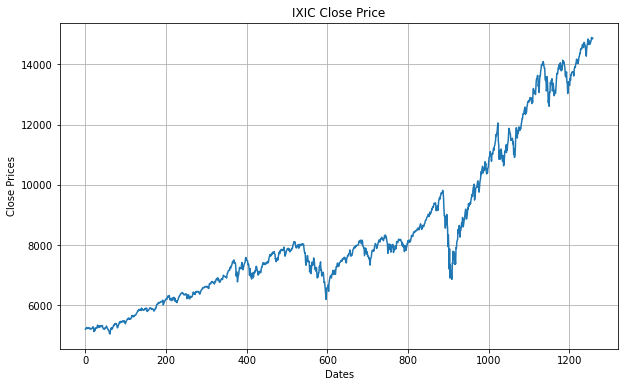

In [5]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Close Prices')
plt.plot(df['Close'])
plt.title('IXIC Close Price')
plt.show()

In [6]:
df.drop(columns=['High', 'Low', 'Open', 'Volume', 'Adj Close', 'Name'], inplace=True)

In [7]:
df

,Date,Close
0,2016-08-10,5204.580078
1,2016-08-11,5228.399902
2,2016-08-12,5232.890137
3,2016-08-15,5262.020020
4,2016-08-16,5227.109863
...,...,...
1254,2021-08-04,14780.530273
1255,2021-08-05,14895.120117
1256,2021-08-06,14835.759766
1257,2021-08-09,14860.179688


In [8]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.head(1)

,Close
Date,
2016-08-10,5204.580078


# Cutoff

In [9]:
cutoff = round(df.shape[0]*0.7)
cutoff

881

# Train/Test split

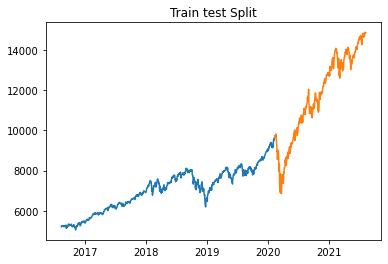

In [10]:
train = df[:cutoff]
test = df[cutoff:]

fig, ax = plt.subplots()
ax.plot(train)
ax.plot(test)
ax.set_title('Train test Split');

In [11]:
test

,Close
Date,
2020-02-11,9638.940430
2020-02-12,9725.959961
2020-02-13,9711.969727
2020-02-14,9731.179688
2020-02-18,9732.740234
...,...
2021-08-04,14780.530273
2021-08-05,14895.120117
2021-08-06,14835.759766


# Random walk

In [12]:
random_walk = train.shift(1)
random_walk

,Close
Date,
2016-08-10,NaN
2016-08-11,5204.580078
2016-08-12,5228.399902
2016-08-15,5232.890137
2016-08-16,5262.020020
...,...
2020-02-04,9273.400391
2020-02-05,9467.969727
2020-02-06,9508.679688


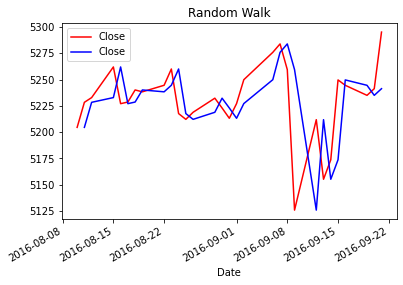

In [13]:
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
random_walk[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('Random Walk')
ax.legend();

In [14]:
np.sqrt(mean_squared_error(train[1:], random_walk.dropna()))

70.93847408128514

In [15]:
residuals = random_walk[1:] - train[1:]
mse = (residuals**2).sum()/len(residuals-1)
np.sqrt(mse)

Close    70.938474
dtype: float64

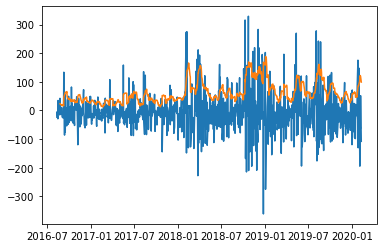

In [16]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals)
ax.plot(residuals.index, residuals.rolling(10).std());

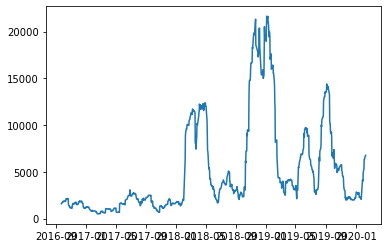

In [17]:
fig, ax = plt.subplots()

ax.plot(residuals.index, residuals.rolling(30).var());

In [18]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  881
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4999.061
Date:                Tue, 10 Aug 2021   AIC                          10000.123
Time:                        09:12:58   BIC                          10004.903
Sample:                             0   HQIC                         10001.951
                                - 881                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5032.2688    145.922     34.486      0.000    4746.266    5318.271
===================================================================================
Ljung-Box (L1) (Q):                   2.62   Jarque-Bera (JB):               535.33
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               4.58   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [19]:
y_hat_rw = random_walk_model.predict(typ='levels')
np.sqrt(mean_squared_error(train, y_hat_rw))

189.1376236588409

# Autoregressive Model

In [20]:
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()
ar_1.predict(typ='levels')

Date
2016-08-10       0.000000
2016-08-11    5203.294525
2016-08-12    5227.226006
2016-08-15    5232.668847
2016-08-16    5260.584431
                 ...     
2020-02-04    9267.365278
2020-02-05    9458.380895
2020-02-06    9506.673406
2020-02-07    9569.022406
2020-02-10    9523.054736
Name: predicted_mean, Length: 881, dtype: float64

In [21]:
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  881
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -4997.993
Date:                Tue, 10 Aug 2021   AIC                           9999.986
Time:                        09:12:58   BIC                          10009.546
Sample:                             0   HQIC                         10003.642
                                - 881                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0493      0.024     -2.025      0.043      -0.097      -0.002
sigma2      5025.0376    147.430     34.084      0.000    4736.079    5313.996
===================================================================================
Ljung-Box (L1) (Q):                   0.06   Jarque-Bera (JB):               537.12
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.61   Skew:                            -0.67
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
ar_1.aic

9999.985750938647

In [23]:
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  881
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -4999.061
Date:                Tue, 10 Aug 2021   AIC                          10000.123
Time:                        09:12:58   BIC                          10004.903
Sample:                             0   HQIC                         10001.951
                                - 881                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      5032.2688    145.922     34.486      0.000    4746.266    5318.271
===================================================================================
Ljung-Box (L1) (Q):                   2.62   Jarque-Bera (JB):               535.33
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               4.58   Skew:                            -0.62
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.62
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Random Walk AIC: 10000.122591298143
AR(1, 1, 0) AIC: 9999.985750938647


# AutoRegressive 2

In [25]:
ar_2 = ARIMA(train, order=(3, 1, 0)).fit()

ar_2.predict(typ='levels')

Date
2016-08-10       0.000000
2016-08-11    5203.295464
2016-08-12    5225.714329
2016-08-15    5232.493349
2016-08-16    5261.452926
                 ...     
2020-02-04    9276.716546
2020-02-05    9444.621864
2020-02-06    9501.595660
2020-02-07    9575.890816
2020-02-10    9521.433561
Name: predicted_mean, Length: 881, dtype: float64

In [26]:
print(ar_2.aic)

9999.084998799242


# Moving Average

In [27]:
ma_1 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

Date
2016-08-10       0.000000
2016-08-11    5203.420872
2016-08-12    5226.003334
2016-08-15    5231.335892
2016-08-16    5260.236509
                 ...     
2020-02-04    9275.152242
2020-02-05    9453.098924
2020-02-06    9496.510742
2020-02-07    9565.837756
2020-02-10    9518.894405
Name: predicted_mean, Length: 881, dtype: float64

In [28]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Close   No. Observations:                  881
Model:                 ARIMA(0, 1, 2)   Log Likelihood               -4996.779
Date:                Tue, 10 Aug 2021   AIC                           9999.558
Time:                        09:12:58   BIC                          10013.898
Sample:                             0   HQIC                         10005.042
                                - 881                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0470      0.024     -1.932      0.053      -0.095       0.001
ma.L2         -0.0495      0.024     -2.080      0.038      -0.096      -0.003
sigma2      5006.0008    147.097     34.032      0.000    4717.696    5294.305
===================================================================================
Ljung-Box (L1) (Q):                   0.07   Jarque-Bera (JB):               548.04
Prob(Q):                              0.80   Prob(JB):                         0.00
Heteroskedasticity (H):               4.56   Skew:                            -0.72
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.59
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

# ARMA

In [29]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()
print(arma_21.aic)

9994.724370148295


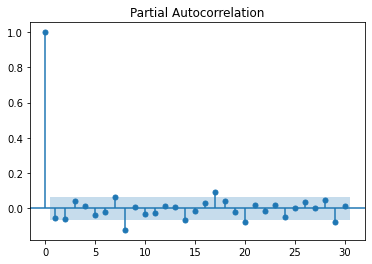

In [30]:
plot_pacf(train.diff().dropna());

# AA model

In [31]:
train

,Close
Date,
2016-08-10,5204.580078
2016-08-11,5228.399902
2016-08-12,5232.890137
2016-08-15,5262.020020
2016-08-16,5227.109863
...,...
2020-02-04,9467.969727
2020-02-05,9508.679688
2020-02-06,9572.150391


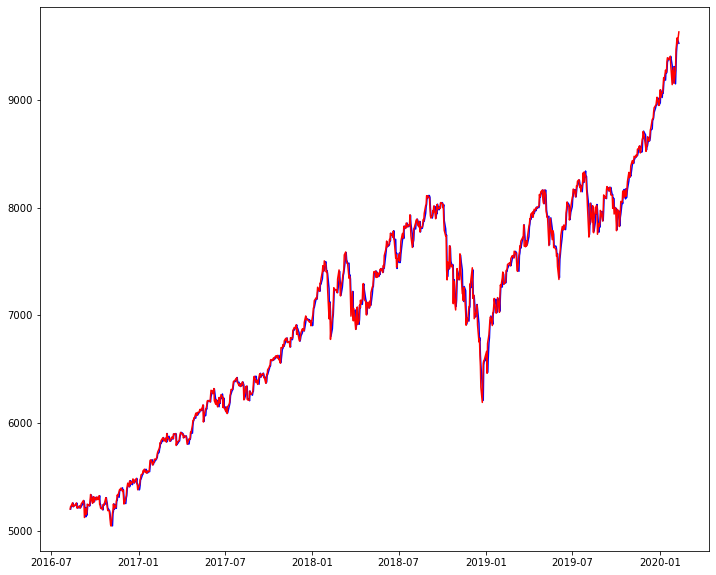

In [34]:
aa_model = ARIMA(res_train, order=(1, 1, 2)).fit()
y_hat_train = aa_model.predict(typ='levels')

fig, ax = plt.subplots(figsize=(12,10))
ax.plot(y_hat_train[1:], color='b')
ax.plot(train, color='r');

In [35]:
y_hat_train = aa_model.predict(start=res_train.index[2], end=res_train.index[-1], typ='levels')

In [36]:
y_hat_train

Date
2016-08-12    5225.828482
2016-08-15    5232.195372
2016-08-16    5260.765027
2016-08-17    5226.460951
2016-08-18    5232.176531
                 ...     
2020-02-04    9286.916742
2020-02-05    9440.384429
2020-02-06    9509.615598
2020-02-07    9563.058382
2020-02-10    9522.690642
Freq: B, Name: predicted_mean, Length: 912, dtype: float64

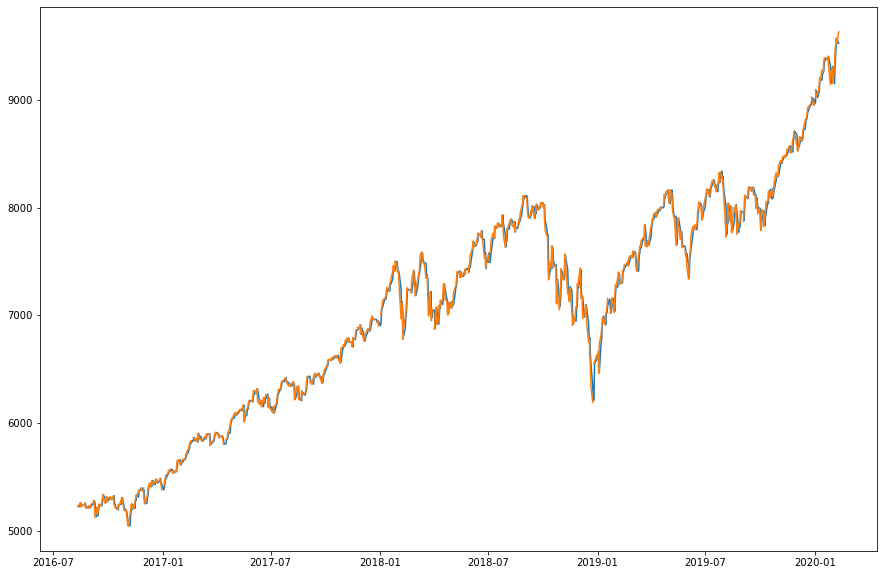

In [37]:
fig, ax = plt.subplots(figsize= (15, 10))
ax.plot(y_hat_train);
ax.plot(train[1:].resample('B').mean())

In [38]:
np.sqrt(mean_squared_error(res_train[2:], y_hat_train))

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [39]:
train.isnull()['Close'] 

Date
2016-08-10    False
2016-08-11    False
2016-08-12    False
2016-08-15    False
2016-08-16    False
              ...  
2020-02-04    False
2020-02-05    False
2020-02-06    False
2020-02-07    False
2020-02-10    False
Name: Close, Length: 881, dtype: bool

In [40]:
train_resample_B = train.resample('B').mean().isnull()

In [41]:
train_resample_B

,Close
Date,
2016-08-10,False
2016-08-11,False
2016-08-12,False
2016-08-15,False
2016-08-16,False
...,...
2020-02-04,False
2020-02-05,False
2020-02-06,False


In [42]:
train_resample_B.loc[train_resample_B['Close'] == True]

,Close
Date,
2016-09-05,True
2016-11-24,True
2016-12-26,True
2017-01-02,True
2017-01-16,True
2017-02-20,True
2017-04-14,True
2017-05-29,True
2017-07-04,True


In [43]:
train.isna().sum()

Close    0
dtype: int64

In [44]:
res_train = train.resample('B').mean()
res_train

,Close
Date,
2016-08-10,5204.580078
2016-08-11,5228.399902
2016-08-12,5232.890137
2016-08-15,5262.020020
2016-08-16,5227.109863
...,...
2020-02-04,9467.969727
2020-02-05,9508.679688
2020-02-06,9572.150391


In [45]:
res_train.ffill(inplace=True)

# Testing

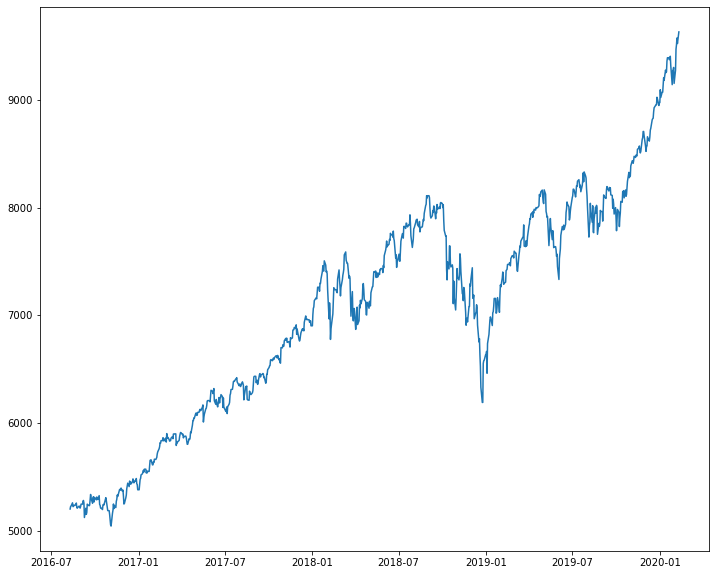

In [46]:
fig, ax = plt.subplots(figsize=(12,10))
ax.plot(res_train);

In [47]:
test.index[-1]

Timestamp('2021-08-10 00:00:00')

In [48]:
test[1:].resample('B').mean().isnull().sum()

Close    13
dtype: int64

In [49]:
test.index[0]

Timestamp('2020-02-11 00:00:00')

In [50]:
train[1:].resample('B').sum().index[-1]

Timestamp('2020-02-10 00:00:00', freq='B')

In [51]:
res_test = test.resample('B').mean()
res_test

,Close
Date,
2020-02-11,9638.940430
2020-02-12,9725.959961
2020-02-13,9711.969727
2020-02-14,9731.179688
2020-02-17,NaN
...,...
2021-08-04,14780.530273
2021-08-05,14895.120117
2021-08-06,14835.759766


In [52]:
res_test.isna().sum()

Close    13
dtype: int64

In [53]:
res_test.ffill(inplace=True)

In [54]:
train.index[-1]

Timestamp('2020-02-10 00:00:00')

In [55]:
test.index[0]

Timestamp('2020-02-11 00:00:00')

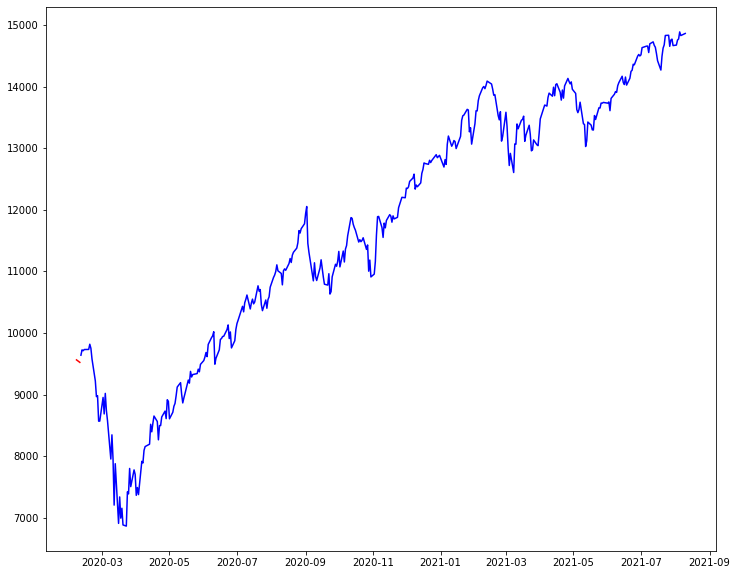

In [56]:
y_hat_test = aa_model.predict(start=pd.to_datetime('2020-02-07'), typ='levels')

fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(y_hat_test, color='r')
ax.plot(test, color='b');

In [57]:
res_test.isnull().sum()

Close    0
dtype: int64

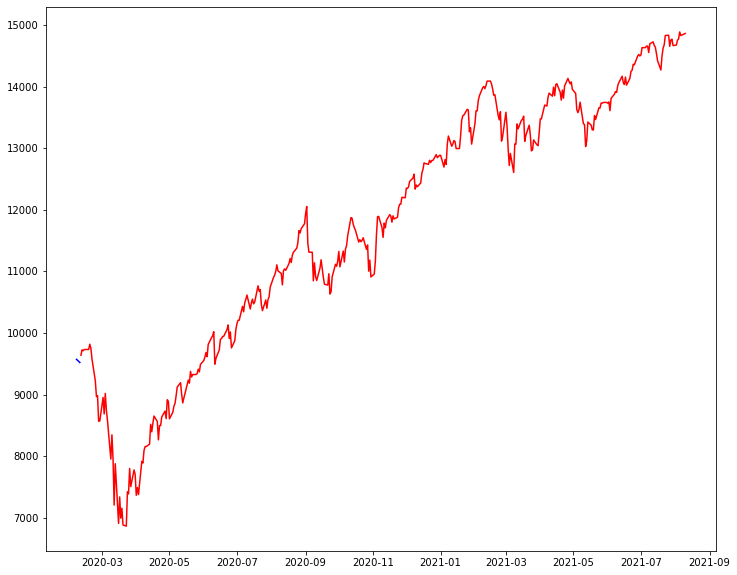

In [58]:
y_hat_rw_test = random_walk_model.predict(start=pd.to_datetime('2020-02-07'),typ='levels')
fig, ax = plt.subplots(figsize=(12, 10))
ax.plot(y_hat_rw_test, color='b')
ax.plot(res_test, color='r');

GridSearch ARIMA Model, and create a SARIMAX model